# VERIFICATION AND VALIDATION: STATIC TESTING

This chapter discusses testing kinetics models. We begin with a motivating example, and then the next two sections provide details of verification testing.
The final section applies these techniques to the running example of glycolytic oscillations.

# Preliminaries

In [ ]:
IS_COLAB = True

In [ ]:
if IS_COLAB:
    !pip install -q SBMLLint
    !pip install -q tellurium
    pass

     |████████████████████████████████| 10.3MB 12.9MB/s 
     |████████████████████████████████| 163kB 47.3MB/s 
     |████████████████████████████████| 6.2MB 37.1MB/s 
     |████████████████████████████████| 122kB 16.1MB/s 
     |████████████████████████████████| 16.6MB 180kB/s 
     |████████████████████████████████| 3.1MB 40.4MB/s 
     |████████████████████████████████| 28.5MB 110kB/s 
     |████████████████████████████████| 36.7MB 80kB/s 
     |████████████████████████████████| 2.0MB 29.1MB/s 
     |████████████████████████████████| 14.9MB 208kB/s 
     |████████████████████████████████| 2.5MB 37.0MB/s 
     |████████████████████████████████| 3.2MB 40.2MB/s 
     |████████████████████████████████| 5.8MB 21.6MB/s 
     |████████████████████████████████| 5.6MB 16.6MB/s 
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is in

In [ ]:
# Python packages used in this section
import matplotlib.pyplot as plt
import numpy as np
import urllib.request # use this library to download file from GitHub
from scipy import fftpack
from SBMLLint.tools.sbmllint import lint
import tellurium as te

In [ ]:
def getSharedCodes(moduleName):
  """
  Obtains common codes from the github repository.

  Parameters
  ----------
  moduleName: str
      name of the python module in the src directory
  """
  if IS_COLAB:
      url = "https://github.com/sys-bio/network-modeling-summer-school-2021/raw/main/src/%s.py" % moduleName
      local_python = "python.py"
      _, _ = urllib.request.urlretrieve(url=url, filename=local_python)
  else:
      local_python = "../../src/%s.py" % moduleName
  with open(local_python, "r") as fd:
    codeStr = "".join(fd.readlines())
  print(codeStr)
  exec(codeStr, globals())

# Acquire codes
getSharedCodes("util")

# TESTS
assert(isinstance(LINEAR_PATHWAY_DF, pd.DataFrame))

import pandas as pd
import urllib.request

# Linear pathway data
BASE_URL = "https://github.com/vporubsky/network-modeling-summer-school/raw/main/"
BASE_DATA_URL = "%sdata/" % BASE_URL
BASE_MODULE_URL = "%ssrc/" % BASE_URL
BASE_MODEL_URL = "%smodels/" % BASE_URL
LOCAL_FILE = "local_file.txt"


def getData(csvFilename):
    """
    Creates a dataframe from a CSV structured URL file.

    Parameters
    ----------
    csvFilename: str
        Name of the CSV file (w/o ".csv" extension)

    Returns
    -------
    pd.DataFrame
    """
    url = "%s%s.csv" % (BASE_DATA_URL, csvFilename)
    filename, _ = urllib.request.urlretrieve(url, filename=LOCAL_FILE)
    return pd.read_csv(LOCAL_FILE)

def getModule(moduleName):
    """
    Obtains common codes from the github repository.
  
    Parameters
    ----------
    moduleName: str
        name of the python module in the src directory
    """
    url = "%s%s.py" % (BASE_MODULE_URL, moduleName)
    _, _ = urllib.request.urlretrieve(url, fil

# Mass Balance Errors

This is a more refined analysis of resolving a mass balance error.
Consider the following simulation of ``ATP`` hydrolysis and ``ADP`` phosphorylation.
We use the equilibrium constant (``Keq``) of 1.
This is not a physiological value for ``Keq``, but useful for our example.

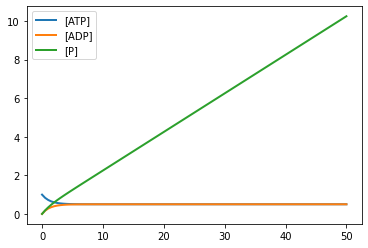

In [ ]:
ATP1_MODEL = """
J0: ATP -> ADP + P; k_f*ATP  
J1: ADP -> ATP; k_r*ADP

Keq = 1
k_f = 0.4
k_r = k_f/Keq
ATP = 1
ADP = 10e-5
"""

rr = te.loada(ATP1_MODEL)
rr.plot(rr.simulate(0, 50, 100))

Our expectation is that at equilibrium, ``ATP = ADP`` by definition of the equilibrium constant.
Instead, ``P`` increases without bound,
and ``ATP = 0 = ADP``.

As we saw in the slides,
the underlying issue is that inorganic phosphate (``P``)
is treated inconsistently:
``P`` appears as a product of hydrolysis,
but ``P`` is not present in ``ATP`` synthesis.

We have a couple of choices for resolving this error.
Below, we revise the model to include ``P`` in
the synthesis reaction.
The revised reaction is ``J1a``.

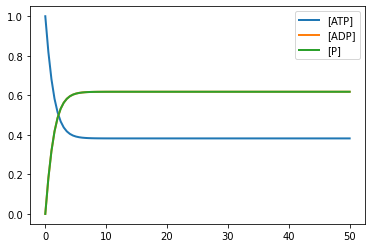

In [ ]:
ATP2_MODEL = """
J0: ATP -> ADP + P; k_f*ATP  
J1a: ADP + P -> ATP; k_r*ADP*P

Keq = 1
k_f = 0.4
k_r = k_f/Keq
ATP = 1
ADP = 10e-5
"""

rr = te.loada(ATP2_MODEL)
rr.plot(rr.simulate(0, 50, 100))

Now, we get a more reasonable result. (Note that the line for ``ADP`` and ``P`` are coincident.) The concentrations of ``ATP`` and ``ADP`` differ because $K_{eq} = \frac{[ATP]}{[ADP] [P]} = \frac{0.64}{(0.4)(0.4)}$.

There is another way of fixing the mass balance error that reqults in ``ATP = ADP``. This solution assumes that there is a
large concentration of ``P`` that is relatively unchanged as a result of the hydolysis and phosphorylation reactions.
So, ``P`` does not appear in the model.

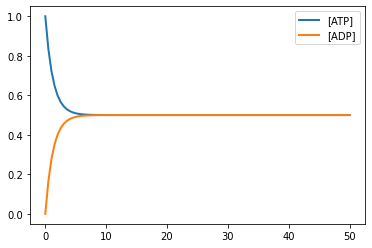

In [ ]:
ATP3_MODEL = """
J0a: ATP -> ADP; k_f*ATP 
J1: ADP -> ATP; k_r*ADP

Keq = 1
k_f = 0.4
k_r = k_f/Keq
ATP = 1
ADP = 10e-5
"""

rr = te.loada(ATP3_MODEL)
rr.plot(rr.simulate(0, 50, 100))

# Detecting Mass Balance Errors

Having seen the dramatic impact of undetected mass balance errors, it is natural to ask how they can be detected. There are two general approaches.
The first requires knowing the chemical composition of each chemical species.
For example, [atomic mass analysis](https://www.nature.com/articles/s41587-020-0446-y) counts the atoms of each type in the reactants and compares each count with the corresponding counts of atoms in the products.
This approach has two challenges.
First, the modeler must use annotations or other means to expose the chemical structure of species; this is not always available (especially
for larger molecules that can be in many different chemical states of phosphorylation, methylation, etc.).
A second problem is that it forces the modeler to write unnecessarly detailed reactions.
For example, ``ATP2_MODEL`` fails this kind of mass balance checking because there is no accounting for the $\gamma$ phosphate of ``ATP``.

An alternative approach is to check for a condition that is a bit weaker than mass balance.
Referred to as **stoichiometric inconsistency**, such inconsistencies are detected if there is no assignment of masses to
the chemical species such that the reaction network (without boundary reactions) neither creates nor destroys chemical species.

The technical details of this latter approach are described in this [article](https://academic.oup.com/bioinformatics/article/37/3/388/5892254).
The paper introduces the GAMES algorithm that uses graphical techniques to analyze mass equivalences implied by the reaction network.
For example, reaction ``J0`` implies that the mass of ``ATP`` is equal to the sum of the masses of ``ADP`` and ``P``.

GAMES is in the SBMLLint ``pip`` installable package. It can be run at the command line
via ``games <SBML file>``. It can also be run programmatically, such as within a Jupyter notebook.
Below, we show how to apply the GAMES to the above examples.


In [ ]:
_ = lint(ATP1_MODEL, mass_balance_check="games")

Model analyzed...
At least one error found.


ADP = ATP by reaction(s):
1. J1: ADP -> ATP

However, ADP < ATP by reaction(s):
2. J0: ATP -> ADP + P


----------------------------------------------------------------------



**********************************************************************




GAMES detected that the first model is stoichiometric inconsisent. Further, GAMES provides a simple argument for how this detection is made.
Statement (1) explains that GAMES inferred that the mass of ``ADP`` is equal to the mass of ``ATP``.
However, this is contradicted by a second finding that the mass of ``ADP`` is less than the mass of ``ATP``.

In [ ]:
_ = lint(ATP2_MODEL, mass_balance_check="games")

Model analyzed...
No error found.


In [ ]:
_ = lint(ATP3_MODEL, mass_balance_check="games")

Model analyzed...
No error found.


# Other Errors Detectable By Static Analysis

There are other errors in reaction networks that can be detected statically. Systems such as MEMOTE detect the following errors:
- *Blocked reactions* are reactions where one or more reactant is never present and so the reaction never ocurs.
- *Dead end metabolite* are chemical species that are produced but not consumed.
- *Orphan metabolites* are chemical species that are consumed but not produced.
- *Charge imbalance* reactions are reactions that do not preserve the charge of the reactants in the products.

The foregoing errors apply to the mass transfer part of reactions. Of course, errors are also possible in the kinetics laws.
Among these errors are:
- *Incorrect reference to chemical species*. To illustrate, consider a reaction in which the modeler intended to use mass action kinetcs, but
wrote the reaction as ``A -> B; k * B``.
- *Errors in the function used in the kinetics law*. A common example here is to inadevertently use zeroth order kinetics for
the degradation of a chemical species.
For example, ``B ->; k``. The problem is that this can result in ``B`` becoming negative since its value is reduced
regardless of whether ``B`` is present. Clearly, we cannot have a negative concentration.

# Exercise

1. Use SBMLLint to find mass check for mass balance errors in the Wolf model.

1. Reaction ``J9`` implies that ``ATP`` and ``ADP`` have the same mass, which is clearly false since they differ
by an inorganic phosphate.
Revise the Wolf model to explicitly include
inorganic phosphate and check your revised model
with SBMLLint.
Do you get the same dynamics with the revised model
as with the original Wolf model?